In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtsmixer import TSMixer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.training import train_tsmixer,train_latent_tsmixer

#add a path to the system path
import sys
sys.path.append('../')
from experiments.datasets import *

seed=42
torch.manual_seed(seed)

In [ ]:
sequence_length = 40
prediction_length = 20
input_channels = 1
n_samples=100
n_timesteps=sequence_length+prediction_length

#generate a Sine dataset
Dataset_generator=SineDataset_AR(n_samples=n_samples, n_timesteps=n_timesteps)
X,ts,ys=Dataset_generator.get_X_ts_ys()

Ys=np.array(ys)
X_torch=torch.tensor(Ys[:,:sequence_length]).float().reshape(n_samples,sequence_length,1)
Y_torch=torch.tensor(Ys[:,sequence_length:]).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

In [ ]:
sequence_length = 40
prediction_length = 20
input_channels = 1
output_channels = 1
n_samples=200
n_timesteps=sequence_length+prediction_length

#generate a Sine dataset
Dataset_generator=SineTransDataset_AR(n_samples=n_samples, n_timesteps=n_timesteps)
X,ts,ys=Dataset_generator.get_X_ts_ys()

Ys1=np.array(ys)
X1_torch=torch.tensor(Ys1[:,:sequence_length]).float().reshape(n_samples,sequence_length,1)
Y1_torch=torch.tensor(Ys1[:,sequence_length:]).float().reshape(n_samples,prediction_length,1)


#generate a Sine dataset
Dataset_generator=SineDataset_AR(n_samples=n_samples, n_timesteps=n_timesteps)
X,ts,ys=Dataset_generator.get_X_ts_ys()
Ys2=np.array(ys)
X2_torch=torch.tensor(Ys2[:,:sequence_length]).float().reshape(n_samples,sequence_length,1)
Y2_torch=torch.tensor(Ys2[:,sequence_length:]).float().reshape(n_samples,prediction_length,1)


X_torch=torch.square(X1_torch+X2_torch)
Y_torch=torch.square(Y1_torch+Y2_torch)
print(X_torch.shape,Y_torch.shape)


In [ ]:
model= TSMixer(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    input_channels=input_channels,
)

best_model, curves, test_loss,test_dataset  = train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=32,
    lr=1e-3,
    device="cpu"  # or "cpu"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from timeview.basis import BSplineBasis
B=5
t=ts[0][sequence_length:]
# Flatten all time arrays together

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]))
Phis = list(bspline.get_all_matrices(np.array(ts)[:,sequence_length:])) # (D, sequence_length, B)

for i in range(B):
    plt.plot(t,Phis[0][:,i])
plt.show()

latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=1,
)

best_latent_model, curves, test_loss,test_dataset = train_latent_tsmixer(
    latent_model,
    X_torch,
    Y_torch,
    Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=32,
    lr=0.001,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for idx in range(15):
    x_example=test_dataset.__getitem__(idx)[0]
    y_example=test_dataset.__getitem__(idx)[1]

    best_latent_model.eval()
    with torch.no_grad():
        h_pred = latent_model(x_example.unsqueeze(0))
    y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()

    best_model.eval()
    with torch.no_grad():
        pred = best_model(x_example.unsqueeze(0))

    plt.plot(ts[0][:sequence_length],x_example.squeeze().numpy(), label='Input')
    plt.plot(ts[0][sequence_length:],y_pred,label='Prediction_BSplineTSMixer')
    plt.plot(ts[0][sequence_length:], pred.squeeze().numpy(), label='Prediction_TSMixer')
    plt.plot(ts[0][sequence_length:], y_example.squeeze().numpy(), label='Target')
    plt.legend()
    plt.show()

In [5]:
sequence_length = 1
prediction_length = 20
input_channels = 1
output_channels = 2
n_samples=200
n_timesteps=prediction_length


X = pd.DataFrame({'x':np.linspace(1.0,3.0,n_samples)})
ts = [np.linspace(0,1,n_timesteps) for i in range(n_samples)]
ys = [2*t*x + np.sin(t*x*np.pi) for t, x in zip(ts, X['x'])]

Ys=np.array(ys)
X_torch=torch.tensor(X.values).float().reshape(n_samples,sequence_length,input_channels)
Y_torch=torch.tensor(Ys).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

torch.Size([200, 1, 1]) torch.Size([200, 20, 1])


c:\Users\nicolas.i.fierro\AppData\Local\anaconda3\envs\timeview\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best Model Test Loss: 0.0594, Best Epoch: 274


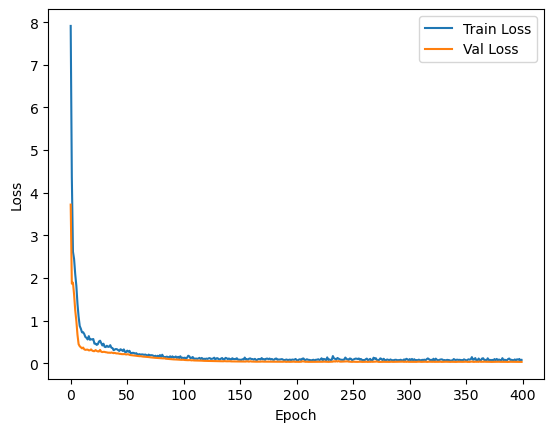

In [6]:
from src.training import train_latent_tsmixer_seasonality
from timeview.basis import BSplineBasis
from timeview.knot_selection import calculate_knot_placement

B=6
t=ts[0]

internal_knots=calculate_knot_placement(ts, ys, n_internal_knots=B-2, T=t[-1],seed=0, verbose=False)

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]),internal_knots=internal_knots)
Phis = list(bspline.get_all_matrices(np.array(ts)))


latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=1,
    output_channels=output_channels
)

best_latent_model, curves, test_loss, test_dataset = train_latent_tsmixer_seasonality(
    latent_model,
    X_torch,
    Y_torch,
    Phis,
    ts,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=400,
    batch_size=32,
    lr=1e-2,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

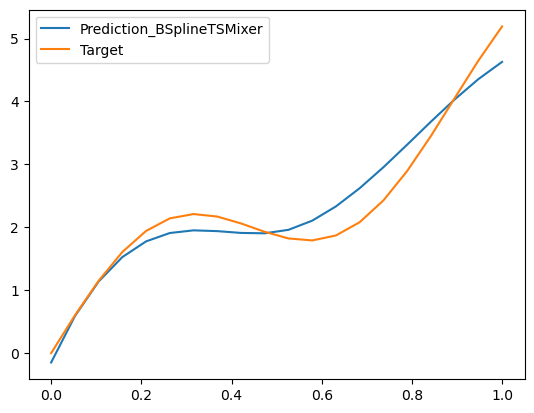

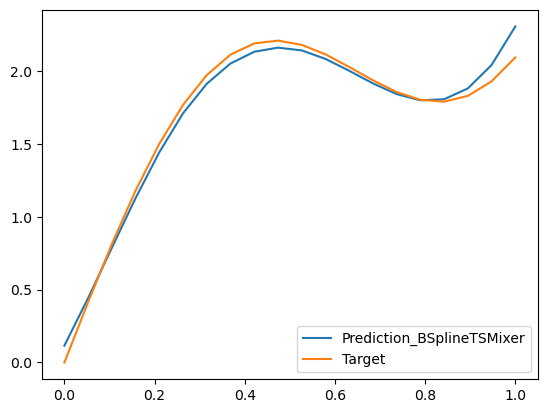

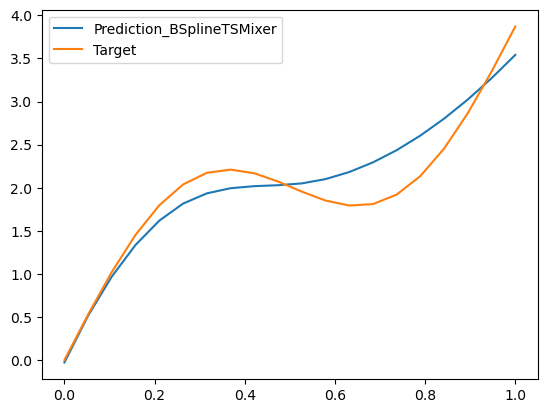

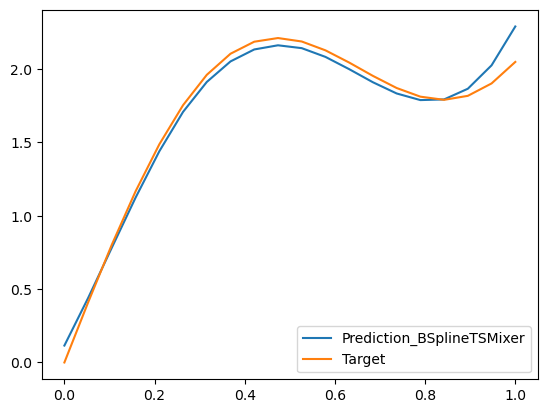

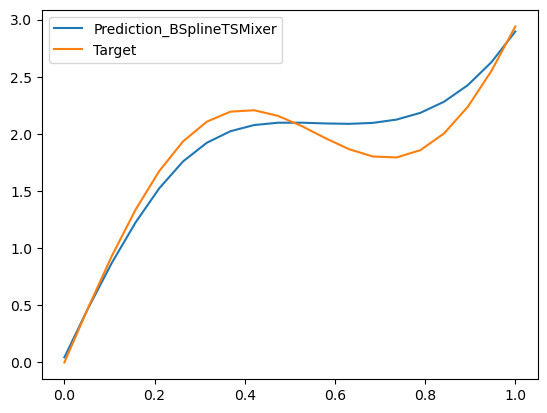

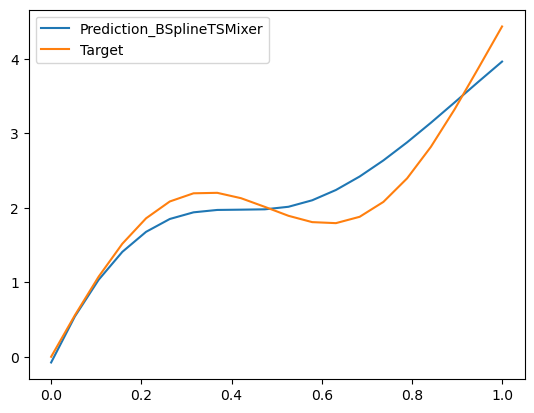

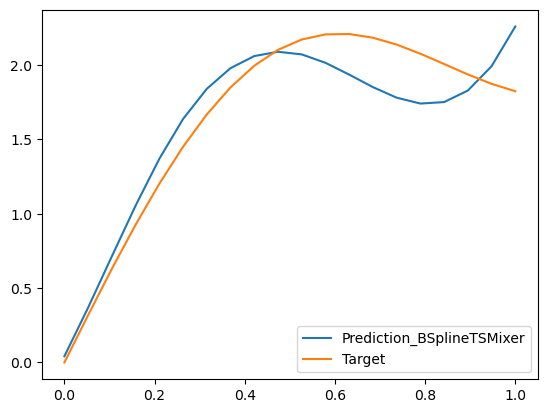

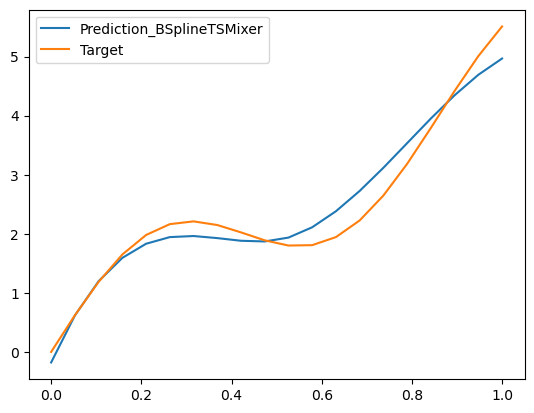

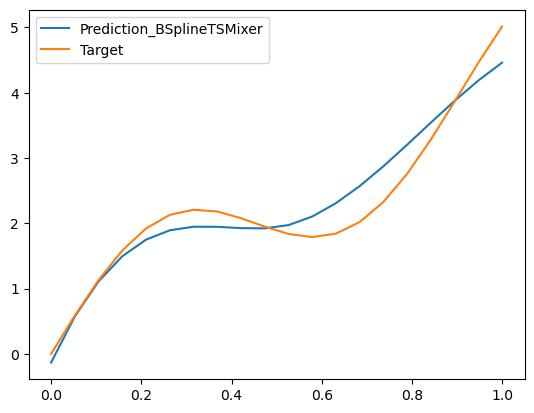

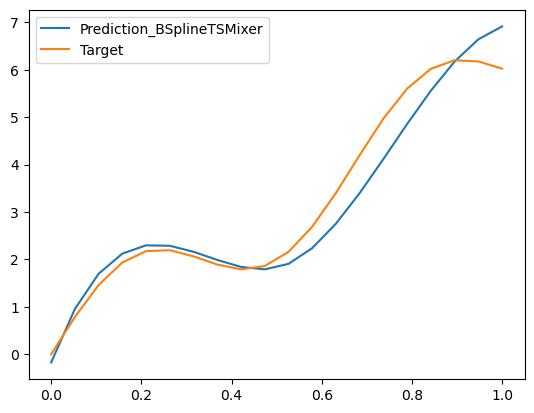

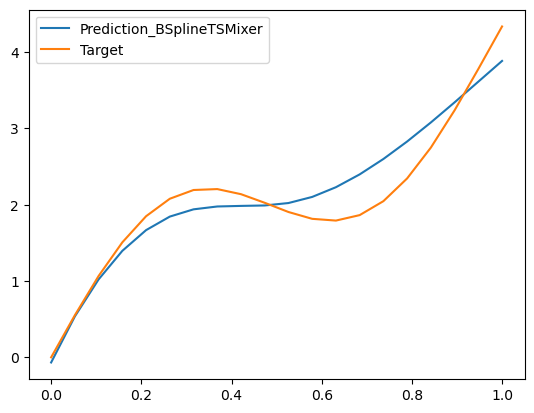

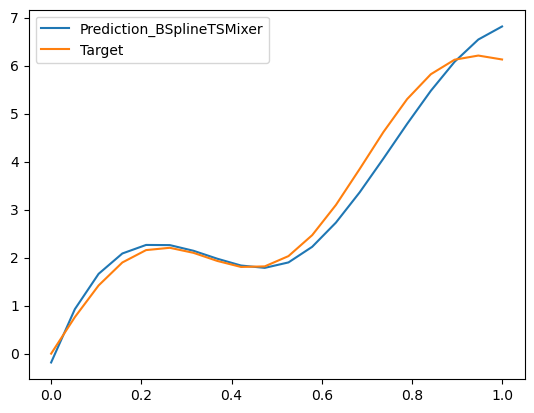

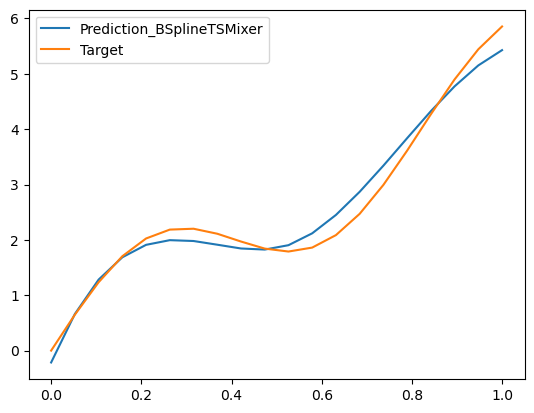

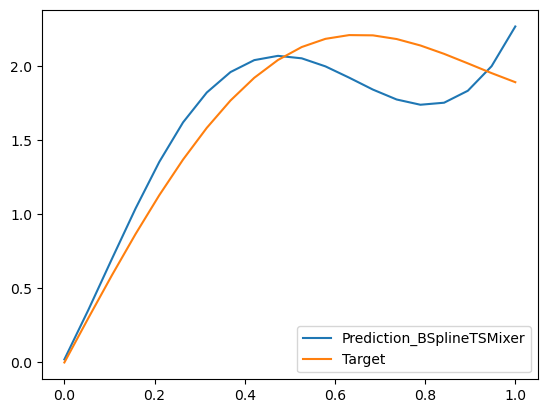

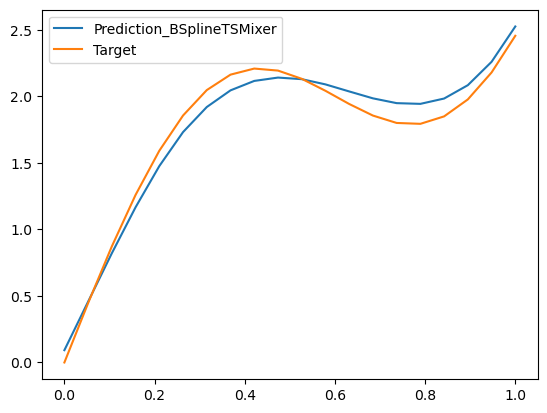

In [7]:
for idx in range(15):
    x_example=test_dataset.__getitem__(idx)[0]
    y_example=test_dataset.__getitem__(idx)[1]

    best_latent_model.eval()
    with torch.no_grad():
        output = best_latent_model(x_example.unsqueeze(0))
        h=output[:,:,0]

        A=output[:,:,1][:,0]
        omega=output[:,:,1][:,1]
        phase=output[:,:,1][:,2]
        y_pred=[torch.matmul(torch.Tensor(Phi),h[d,:]) for d, Phi in enumerate(Phis[:h.shape[0]])]
        y_pred=torch.stack(y_pred)
        # Compute the sinusoidal term (broadcast omega and phase across sequence_length)
        sinusoidal_term = torch.stack([A[i]*torch.sin(omega[i]*torch.tensor(ts[:h.shape[0]])[i]+phase[i]) for i in range(omega.shape[0])])
        # Add the sinusoidal term to y_pred
        y_pred += sinusoidal_term  # Shape (batch_size, sequence_length)

    plt.plot(ts[0],y_pred[0],label='Prediction_BSplineTSMixer')
    plt.plot(ts[0], y_example.squeeze().numpy(), label='Target')
    plt.legend()
    plt.show()